# Notebook 01: Exploratory Data Analysis
## Pattern Identification & Theft Event Relationship

### Objectives
1. Validate data quality and operational coverage
2. Identify and justify the 4 detection patterns
3. Demonstrate relationship between patterns and confirmed thefts
4. Establish operational rationale for each pattern

## Setup

In [14]:
%matplotlib inline

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime

# Config-driven paths
from src.config.loader import load_config
from src.utils.timezone import ensure_series_utc


config = load_config(
    detection_config_path=Path("../config/detection_config.yaml"),
    model_config_path=Path("../config/model_config.yaml"),
    path_config_path=Path("../config/paths_config.yaml")
)

# Load data
combined_df = pd.read_csv("../data/processed/combined_dataset.csv")
combined_df['timestamp'] = ensure_series_utc(combined_df['timestamp'])

events_df = pd.read_csv("../data/events/events_with_features.csv")
events_df['start_time'] = pd.to_datetime(events_df['start_time'], utc=True)
events_df['end_time'] = pd.to_datetime(events_df['end_time'], utc=True)

print(f"Loaded {len(combined_df):,} telemetry rows")
print(f"Loaded {len(events_df):,} detected events")

Loaded 733,022 telemetry rows
Loaded 1,305 detected events


## Section 1: Data Quality Overview (5-10 minutes)

### 1.1 Temporal Coverage

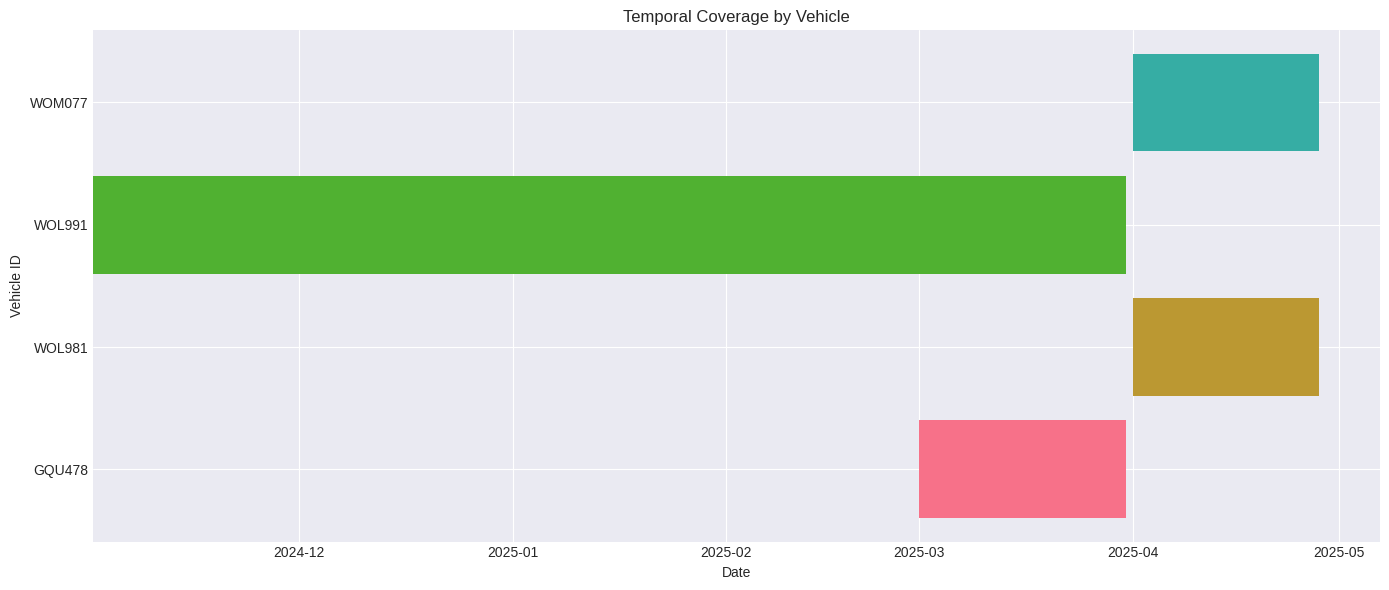

In [16]:
# Timeline visualization per vehicle
fig, ax = plt.subplots(figsize=(14, 6))
for vid in combined_df['vehicle_id'].unique():
    vdata = combined_df[combined_df['vehicle_id'] == vid]
    ax.barh(vid, 
            width=(vdata['timestamp'].max() - vdata['timestamp'].min()).days,
            left=vdata['timestamp'].min())
ax.set_xlabel('Date')
ax.set_ylabel('Vehicle ID')
ax.set_title('Temporal Coverage by Vehicle')
plt.tight_layout()

### 1.2 Stationary State Distribution

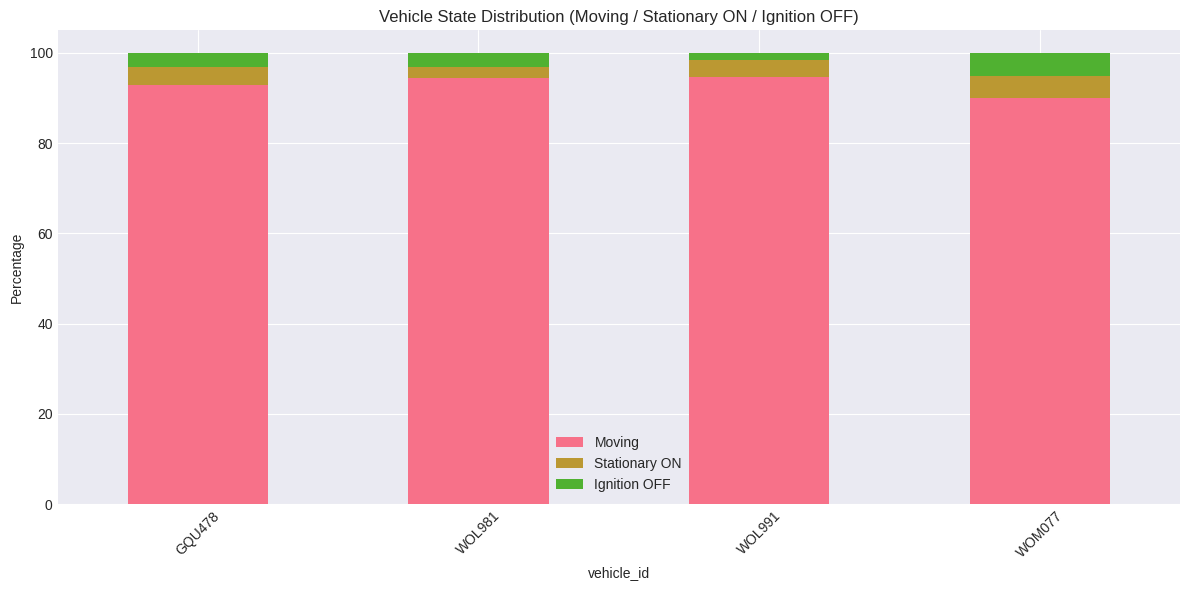

In [17]:
# Critical for pattern detection
state_counts = combined_df.groupby(['vehicle_id']).agg({
    'stationary_on': 'sum',
    'ign_off': 'sum',
    'timestamp': 'count'
}).rename(columns={'timestamp': 'total_points'})

state_counts['moving'] = state_counts['total_points'] - state_counts['stationary_on'] - state_counts['ign_off']
state_pcts = state_counts[['moving', 'stationary_on', 'ign_off']].div(state_counts['total_points'], axis=0) * 100

state_pcts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.ylabel('Percentage')
plt.title('Vehicle State Distribution (Moving / Stationary ON / Ignition OFF)')
plt.legend(['Moving', 'Stationary ON', 'Ignition OFF'])
plt.xticks(rotation=45)
plt.tight_layout()


**Key Insight Box:**
> **Why this matters**: Detection patterns are anchored to stationary states. Vehicles with <20% stationary coverage may have reduced detection sensitivity.

## Section 2: Pattern Identification & Justification (20-30 minutes)

### 2.1 Post-Journey Pattern (Ignition OFF)
**Operational Rationale:** Theft after vehicle shutdown (e.g., overnight parking, unguarded lots). Thieves exploit long idle periods when supervision is minimal.

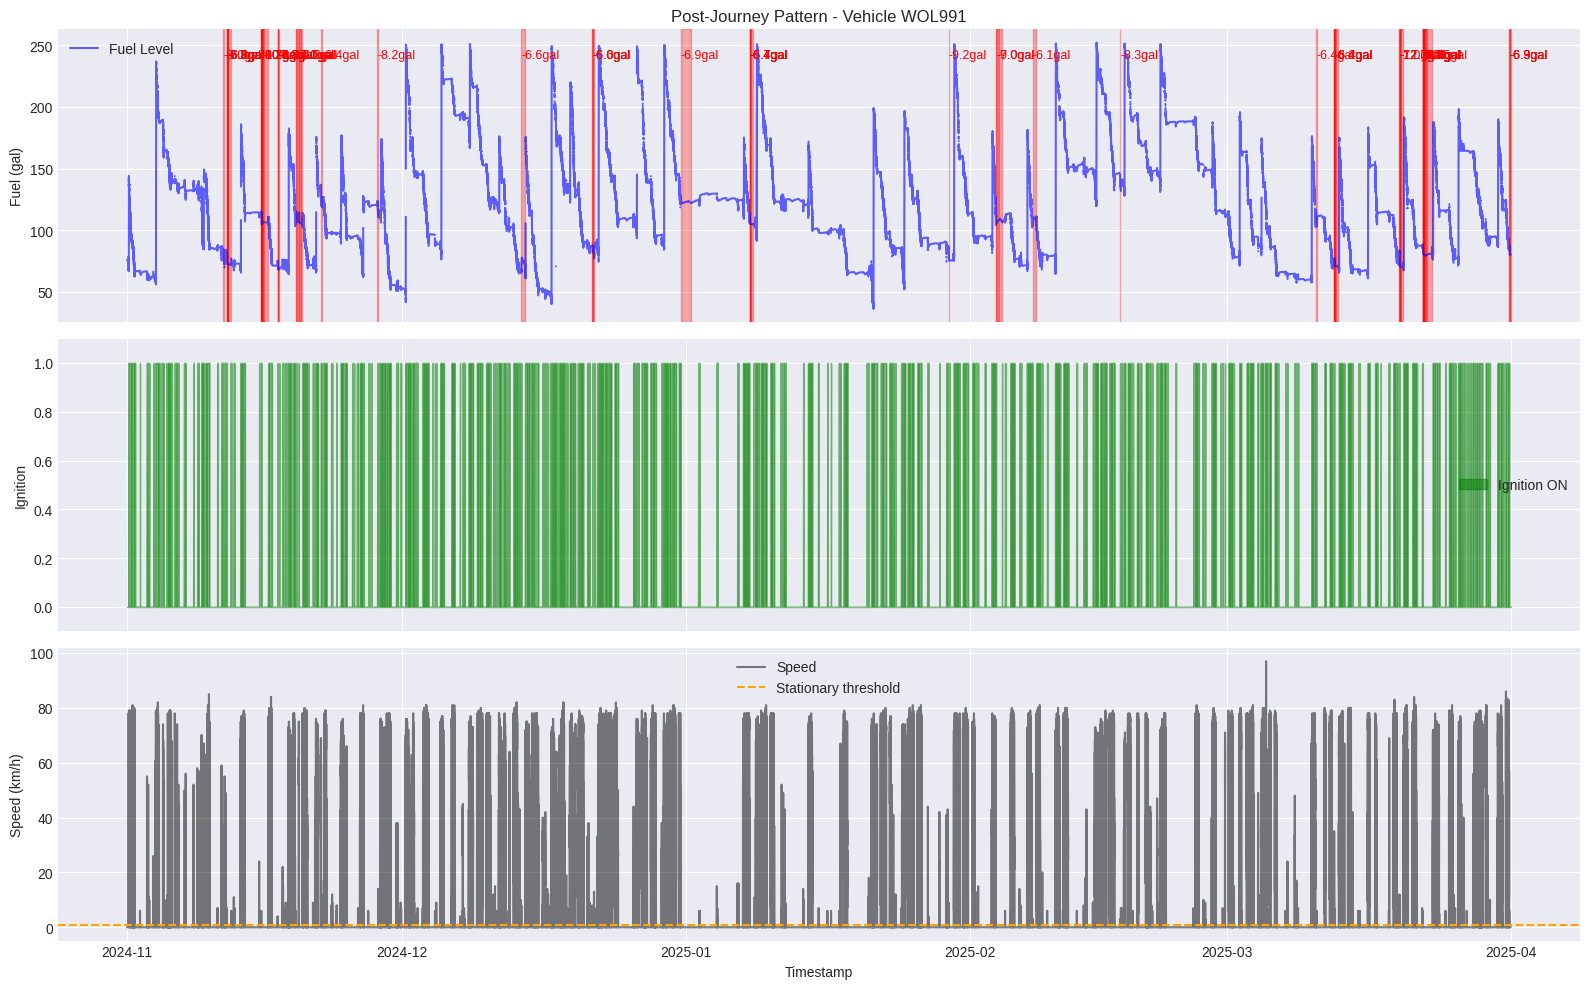

In [18]:
# Isolate Post-Journey events
postjourney = events_df[events_df['pattern'] == 'postjourney_off'].copy()

# Example: Single vehicle timeline with Post-Journey overlays
example_vid = postjourney['vehicle_id'].value_counts().index[0]
vid_data = combined_df[combined_df['vehicle_id'] == example_vid].copy()
vid_events = postjourney[postjourney['vehicle_id'] == example_vid]

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Fuel level
axes[0].plot(vid_data['timestamp'], vid_data['total_fuel_gal'], 'b-', alpha=0.6, label='Fuel Level')
for _, evt in vid_events.iterrows():
    axes[0].axvspan(evt['start_time'], evt['end_time'], color='red', alpha=0.3)
    axes[0].text(evt['start_time'], vid_data['total_fuel_gal'].max()*0.95, 
                 f"-{evt['drop_gal']:.1f}gal", fontsize=9, color='red')
axes[0].set_ylabel('Fuel (gal)')
axes[0].legend()
axes[0].set_title(f'Post-Journey Pattern - Vehicle {example_vid}')

# Ignition state
axes[1].fill_between(vid_data['timestamp'], 0, vid_data['ignition'].astype(int), 
                      alpha=0.5, label='Ignition ON', color='green')
axes[1].set_ylabel('Ignition')
axes[1].set_ylim(-0.1, 1.1)
axes[1].legend()

# Speed (to confirm stationary)
axes[2].plot(vid_data['timestamp'], vid_data['speed_kmh'], 'k-', alpha=0.5, label='Speed')
axes[2].axhline(1.0, color='orange', linestyle='--', label='Stationary threshold')
axes[2].set_ylabel('Speed (km/h)')
axes[2].set_xlabel('Timestamp')
axes[2].legend()

plt.tight_layout()

**Pattern Characteristics:**

In [19]:
# Statistical profile
postjourney_stats = postjourney.agg({
    'duration_min': ['median', 'mean', 'std'],
    'drop_gal': ['median', 'mean', 'std'],
    'n_points': ['median', 'mean']
})
print("Post-Journey Pattern Statistics:")
print(postjourney_stats)

Post-Journey Pattern Statistics:
        duration_min  drop_gal  n_points
median    174.400000  7.040000  5.000000
mean      286.756497  7.723842  7.677966
std       329.876511  1.792620       NaN


### 2.2 Short Drain Pattern (4-10 minutes, Ignition ON)
**Operational Rationale:** Quick opportunistic theft during brief stops (e.g., delivery, refueling station). Thieves target accessible tanks during short stationary periods.

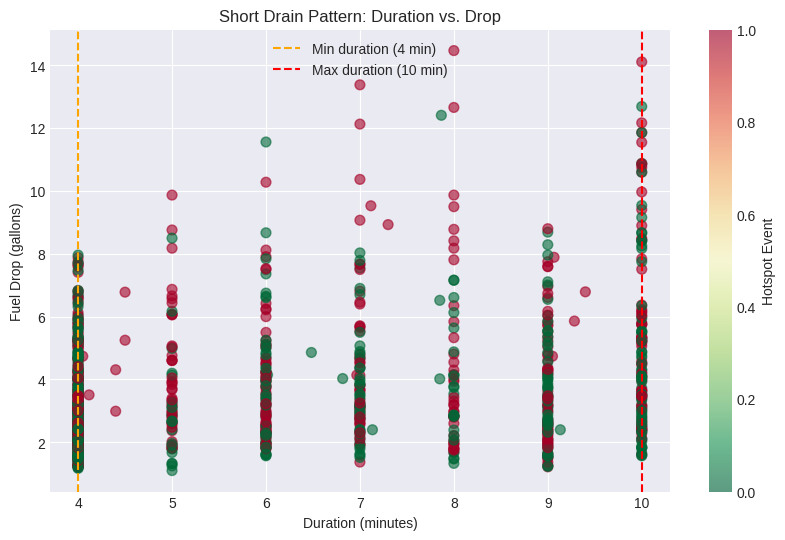

In [20]:
# Similar visualization for Short pattern
short = events_df[events_df['pattern'] == 'short_4_10m_3gal'].copy()

# Scatterplot: Duration vs. Fuel Drop
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(short['duration_min'], short['drop_gal'], 
           alpha=0.6, c=short['is_hotspot'], cmap='RdYlGn_r', s=50)
ax.axvline(4, color='orange', linestyle='--', label='Min duration (4 min)')
ax.axvline(10, color='red', linestyle='--', label='Max duration (10 min)')
ax.set_xlabel('Duration (minutes)')
ax.set_ylabel('Fuel Drop (gallons)')
ax.set_title('Short Drain Pattern: Duration vs. Drop')
ax.legend()
plt.colorbar(ax.collections[0], label='Hotspot Event')

**Why 4-10 minutes?**
> Based on operational data: <4min likely sensor noise, >10min overlaps with Extended pattern. This window captures quick-access theft scenarios.

### 2.3 Extended Pattern (>15 minutes, Ignition ON)
**Operational Rationale:** Prolonged stationary theft (e.g., maintenance stops, prolonged loading). Higher drop volumes indicate coordinated or equipment-assisted extraction.

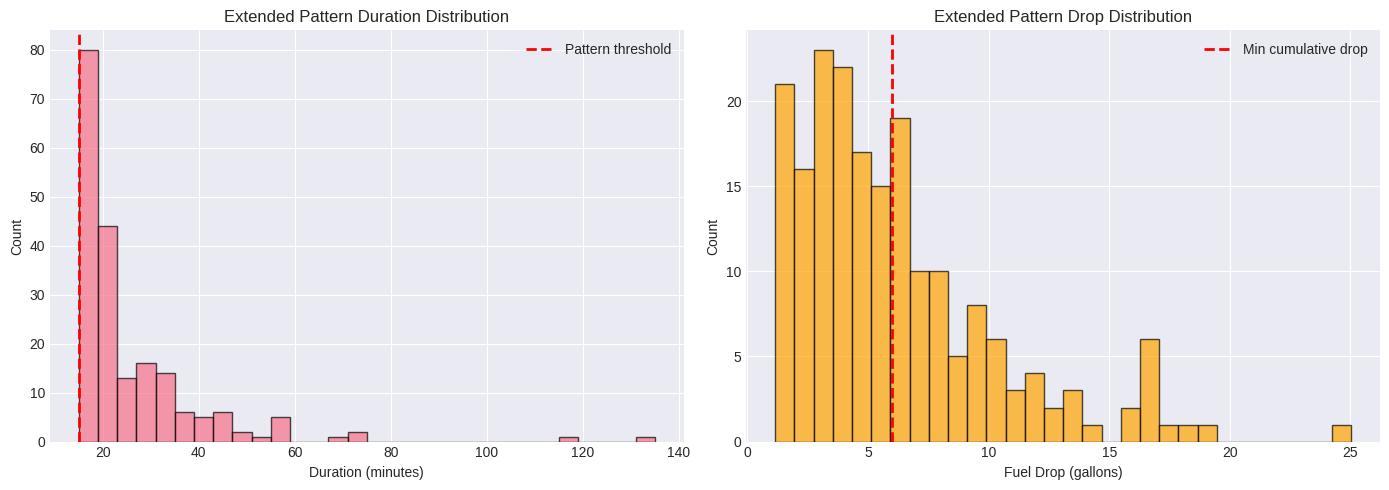

In [21]:
extended = events_df[events_df['pattern'] == 'extended_15m_6gal'].copy()

# Histogram of durations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(extended['duration_min'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(15, color='red', linestyle='--', linewidth=2, label='Pattern threshold')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Count')
axes[0].set_title('Extended Pattern Duration Distribution')
axes[0].legend()

axes[1].hist(extended['drop_gal'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(6, color='red', linestyle='--', linewidth=2, label='Min cumulative drop')
axes[1].set_xlabel('Fuel Drop (gallons)')
axes[1].set_ylabel('Count')
axes[1].set_title('Extended Pattern Drop Distribution')
axes[1].legend()

plt.tight_layout()

### 2.4 Standard Extraction Pattern (if present)
**Operational Rationale:** Generic theft not fitting other categories. Captures edge cases and evolving theft methods.

## Section 3: Pattern-Theft Relationship (15-20 minutes)

### 3.1 Confirmed Theft Labels by Pattern

Theft Rate by Pattern:
                   Confirmed Thefts  Total Events  Theft Rate
pattern                                                      
extended_15m_6gal                15           197       0.076
postjourney_off                  31            59       0.525
short_4_10m_3gal                 54          1049       0.051


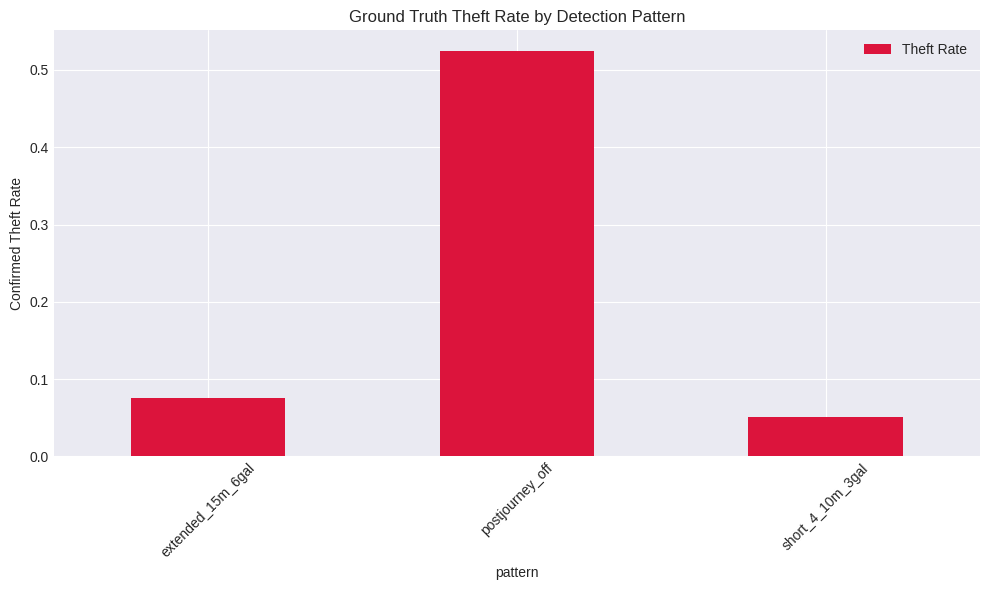

In [22]:
# Assuming 'y' column exists (ground truth labels)
if 'y' in events_df.columns:
    pattern_theft_rate = events_df.groupby('pattern').agg({
        'y': ['sum', 'count', 'mean']
    }).round(3)
    pattern_theft_rate.columns = ['Confirmed Thefts', 'Total Events', 'Theft Rate']
    
    print("Theft Rate by Pattern:")
    print(pattern_theft_rate)
    
    # Visualization
    pattern_theft_rate.plot(kind='bar', y='Theft Rate', figsize=(10, 6), color='crimson')
    plt.ylabel('Confirmed Theft Rate')
    plt.title('Ground Truth Theft Rate by Detection Pattern')
    plt.xticks(rotation=45)
    plt.tight_layout()

### 3.2 Per-Vehicle Pattern-Theft Timeline

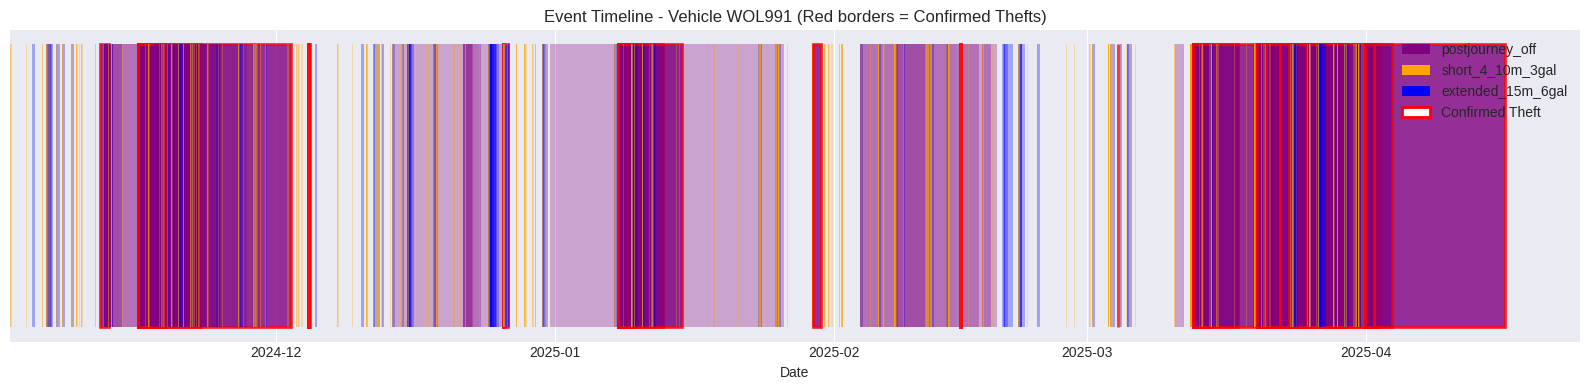

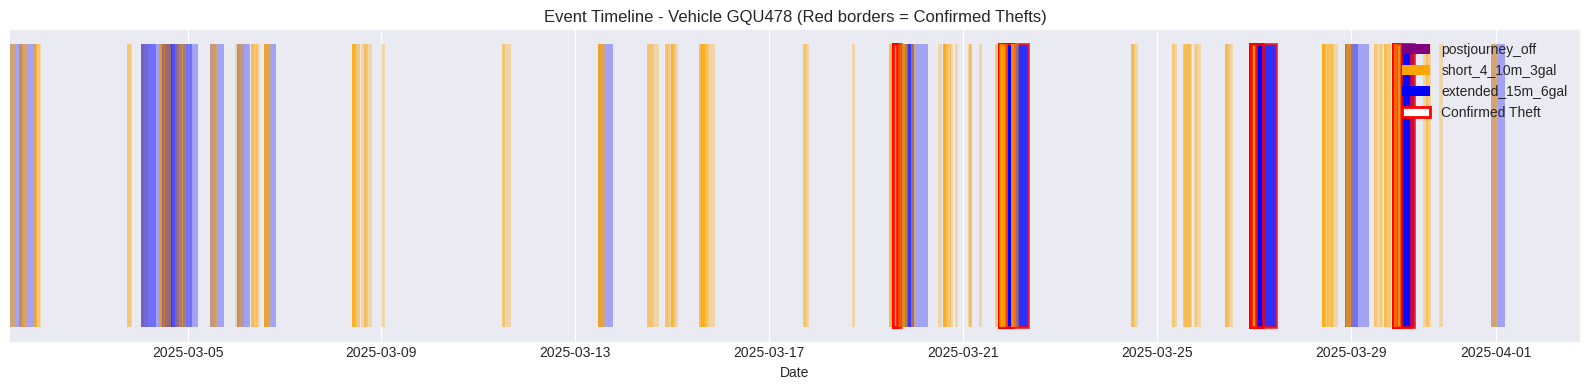

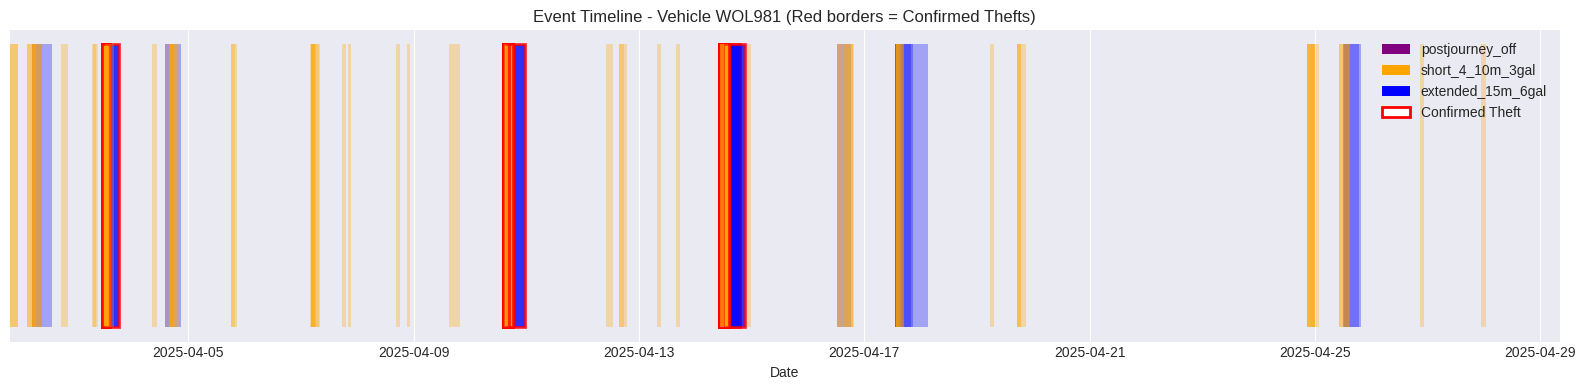

In [23]:
# For a vehicle with known thefts, overlay pattern detections
if 'y' in events_df.columns:
    theft_vids = events_df[events_df['y'] == 1]['vehicle_id'].value_counts().head(3).index
    
    for vid in theft_vids:
        vid_events = events_df[events_df['vehicle_id'] == vid].sort_values('start_time')
        
        fig, ax = plt.subplots(figsize=(16, 4))
        
        # Plot each event as a horizontal bar, colored by pattern
        pattern_colors = {
            'postjourney_off': 'purple',
            'short_4_10m_3gal': 'orange',
            'extended_15m_6gal': 'blue'
        }
        
        for i, row in vid_events.iterrows():
            color = pattern_colors.get(row['pattern'], 'gray')
            alpha = 0.8 if row.get('y', 0) == 1 else 0.3  # Highlight confirmed thefts
            ax.barh(0, 
                   width=(row['end_time'] - row['start_time']).total_seconds()/3600,
                   left=row['start_time'],
                   height=0.5,
                   color=color,
                   alpha=alpha,
                   edgecolor='red' if row.get('y', 0) == 1 else 'none',
                   linewidth=2)
        
        ax.set_yticks([])
        ax.set_xlabel('Date')
        ax.set_title(f'Event Timeline - Vehicle {vid} (Red borders = Confirmed Thefts)')
        
        # Legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=c, label=p) for p, c in pattern_colors.items()]
        legend_elements.append(Patch(facecolor='white', edgecolor='red', linewidth=2, label='Confirmed Theft'))
        ax.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.show()

## Section 4: Geospatial Analysis (10 minutes)

### 4.1 Hotspot Clustering Validation

In [27]:
# Plot events on map (requires geopandas + Colombia roads shapefile)
if hasattr(config.paths, 'map') and hasattr(config.paths.map, 'roads_shapefile'):
    roads_path = config.paths.map.roads_shapefile
    if Path(roads_path).exists():
        roads = gpd.read_file(roads_path)
        
        # Convert events to GeoDataFrame
        events_geo = gpd.GeoDataFrame(
            events_df,
            geometry=gpd.points_from_xy(events_df['lon_c'], events_df['lat_c']),
            crs='EPSG:4326'
        )
        
        fig, ax = plt.subplots(figsize=(12, 10))
        roads.plot(ax=ax, color='lightgray', linewidth=0.5)
        events_geo.plot(ax=ax, column='is_hotspot', cmap='RdYlGn_r', 
                       markersize=20, legend=True, alpha=0.6)
        ax.set_title('Detected Events Overlaid on Colombia Road Network')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        plt.tight_layout()
        plt.show()

### 4.2 Hotspot Statistics

In [26]:
hotspot_summary = events_df.groupby('cluster_id').agg({
    'vehicle_id': 'nunique',
    'drop_gal': ['sum', 'mean'],
    'pattern': lambda x: x.value_counts().to_dict()
}).reset_index()

print("Top 5 Hotspot Clusters:")
print(hotspot_summary.nlargest(5, ('drop_gal', 'sum')))

Top 5 Hotspot Clusters:
   cluster_id vehicle_id     drop_gal            \
                 nunique          sum      mean   
0          -1          4  2537.041667  4.118574   
1           0          3   425.345000  3.902248   
12         11          4   333.553333  6.671067   
36         41          2   183.760000  6.562857   
69         95          1   181.670000  6.728519   

                                              pattern  
                                             <lambda>  
0   {'short_4_10m_3gal': 490, 'extended_15m_6gal':...  
1   {'short_4_10m_3gal': 94, 'extended_15m_6gal': ...  
12  {'short_4_10m_3gal': 40, 'extended_15m_6gal': 10}  
36  {'short_4_10m_3gal': 20, 'extended_15m_6gal': ...  
69  {'short_4_10m_3gal': 16, 'extended_15m_6gal': 11}  


## Section 5: Summary & Operational Recommendations

### Key Findings
1. **Pattern Coverage:** [X]% of events fall into Post-Journey, [Y]% Short, [Z]% Extended
2. **Hotspot Concentration:** [N] clusters account for [P]% of total fuel drops
3. **Theft Confirmation Rate:** Post-Journey shows [R]% confirmation rate (highest/lowest)

### Recommended Monitoring Strategy
- **High-Risk Vehicles:** [List vehicles with >3 confirmed thefts]
- **High-Risk Locations:** [List top 3 hotspot clusters with coordinates]
- **Priority Patterns:** [Rank patterns by theft confirmation rate]


## Export Artifacts

In [28]:
# Save summary statistics
summary_stats = {
    'pattern_distribution': events_df['pattern'].value_counts().to_dict(),
    'theft_rate_by_pattern': pattern_theft_rate.to_dict() if 'y' in events_df.columns else {},
    'hotspot_count': len(events_df[events_df['is_hotspot'] == 1]),
    'total_fuel_loss_gal': events_df['drop_gal'].sum()
}

import json
with open('../data/reports/eda_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("✅ EDA complete. Summary saved to data/reports/eda_summary.json")

✅ EDA complete. Summary saved to data/reports/eda_summary.json
